# 1. Setup

## 1.1 Install Dependencies

In [1]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

## 1.2 Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
print(tf.config.experimental.list_physical_devices())
#for gpu in gpus: 
   # tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## 1.4 Create Folder Structures

In [13]:
# Setup paths
POS_PATH = os.path.join('..', 'data', 'positive')
NEG_PATH = os.path.join('..', 'data', 'negative')
ANC_PATH = os.path.join('..', 'data', 'anchor')

In [14]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [15]:
# http://vis-www.cs.umass.edu/lfw/

In [16]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
#!tar -xf lfw.tgz

In [17]:
# # Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)


## 2.2 Collect Positive and Anchor Classes

In [45]:
os.system('python capture.py')

0

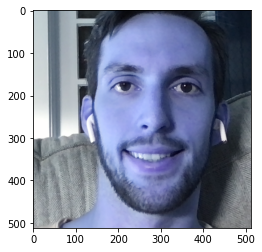

In [46]:
plt.imshow(np.load('../test_images/last_frame.npy'))

# 2.x NEW - Data Augmentation

In [9]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [11]:
import os
import uuid

In [12]:
img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [50]:
take_n = 50

anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(take_n)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(take_n)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(take_n)

In [51]:
dir_test = anchor.as_numpy_iterator()

In [54]:
print(dir_test.next())

b'../data/anchor/dba1e4f4-e44e-11ec-af47-acde48001122.jpg'


## 3.2 Preprocessing - Scale and Resize

In [9]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [176]:
img = preprocess('data\\anchor\\a4e73462-135f-11ec-9e6e-a0cec8d2d278.jpg')

In [177]:
img.numpy().max() 

1.0

In [178]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

## 3.3 Create Labelled Dataset

In [179]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [180]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [181]:
samples = data.as_numpy_iterator()

In [182]:
exampple = samples.next()

In [183]:
exampple

(b'data\\anchor\\5b0483e2-33a9-11ec-9085-a0cec8d2d278.jpg',
 b'data\\positive\\7dfdedca-33a9-11ec-ad17-a0cec8d2d278.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [184]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [185]:
res = preprocess_twin(*exampple)

# 4. Model Engineering

## 4.1 Build Embedding Layer

## 4.2 Build Distance Layer

## 4.3 Make Siamese Model

# 5. Training

## 5.1 Setup Loss and Optimizer

## 5.2 Establish Checkpoints

## 5.3 Build Train Step Function

## 5.4 Build Training Loop

## 5.5 Train the model

# 6. Evaluate Model

## 6.1 Import Metrics

## 6.2 Make Predictions

## 6.3 Calculate Metrics

## 6.4 Viz Results

# 7. Save Model

# 8. Real Time Test

## 8.1 Verification Function

## 8.2 OpenCV Real Time Verification